In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
from jax.scipy.special import logsumexp
import numpy as np
import mcmc_infinity as mc
import emcee
import corner

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

seed = 12345

# Problem

Here we try to find the number of pulse signals in time-series data. The pulses are given by

$$ f(t) = a \exp\left(-\frac{(t - b)^2}{2 c^2}\right), $$

where $a,\,b,\, c$ are the unknown parameters of each pulse.

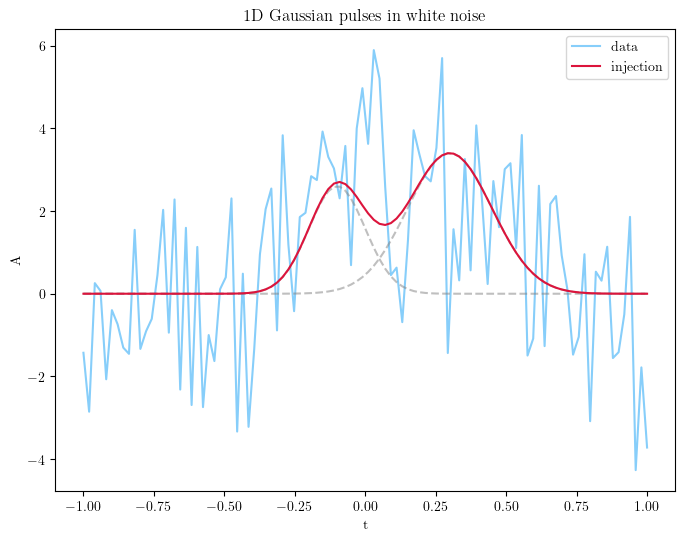

In [2]:
t, y, sigma, p_inj = mc.test_functions.multiple_pulses.gen_data()

In [3]:
dim = 3
target = mc.test_functions.multiple_pulses.llh_pulses(t, y, sigma=sigma, dim=dim)

# Uniform Proposal

Create a uniform proposal distribution with the prior bounds for each pulse.

In [4]:
bounds = np.array([[2.5, 3.5], [-0.2, 0.4], [0.05, 0.2]])
kbounds = np.array([1, 3])

uniform_proposal = mc.uniform_proposal_transd.UniformProposalTransD(dim, bounds, kbounds)

Create two starting points, same k for now.

In [5]:
starting_pos = np.repeat(np.array(p_inj)[np.newaxis, :, :], 2, axis=0)

for i in range(starting_pos.shape[0]):
    for r in range(starting_pos.shape[1]):
        starting_pos[i, r] += np.random.multivariate_normal(np.zeros( starting_pos.shape[2] ), 1e-2*np.eye(starting_pos.shape[2]))

Initialise the perfect sampler.

In [6]:
sampler_uniform = mc.sampler.PerfectSampler(target, 
                                            uniform_proposal, 
                                            np.array(starting_pos), 
                                            seed=seed,
                                            rj=True,
                                            kmax=kbounds[1])

Run the perfect sampler. This will be quite slow because the uniform proposal is inefficient; we will explore more efficient KDE proposals below.

In [7]:
T = 2

num_samples = 2000

samples_uniform, T_uniform = sampler_uniform.get_perfect_samples(T, 
                                                                num_samples, 
                                                                return_T=True)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/nikos/work/programs/anaconda3/envs/perfect_transsampling/lib/python3.13/site-packages/jax/_src/ops/scatter.py:108: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 2000/2000 [10:42<00:00,  3.11it/s]


Mask the nans, get the samples for each Gaussian pulse

In [8]:
samples = samples_uniform.reshape(-1, dim) # reshape, put all components in rows (even empty slots)
mask = ~jnp.any(jnp.isnan(samples), axis=1) # handle empty entries of components (nans)
samples = samples[mask]

Make a corner plot

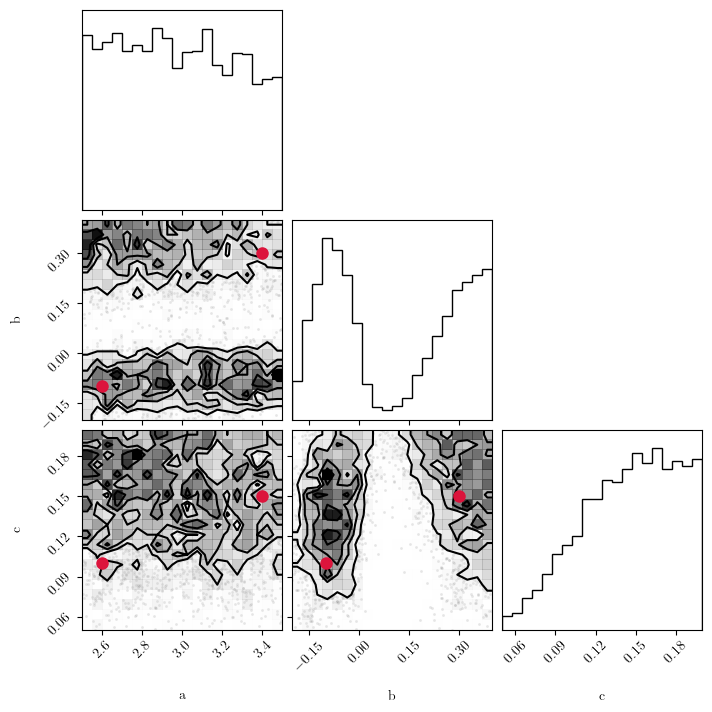

In [9]:
figure = corner.corner(np.array(samples), labels=["a","b", "c"])

for pulse_params in np.array(p_inj):
    corner.overplot_points(figure, pulse_params[None], marker="o", color="crimson", markersize=8)
plt.show()

Count the number of non-nan entries, make a histogram of the number of components of the nested model

<>:11: SyntaxWarning: invalid escape sequence '\#'
<>:11: SyntaxWarning: invalid escape sequence '\#'
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_82611/1785326494.py:11: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("\# of pulses")


Text(0.5, 0, '\\# of pulses')

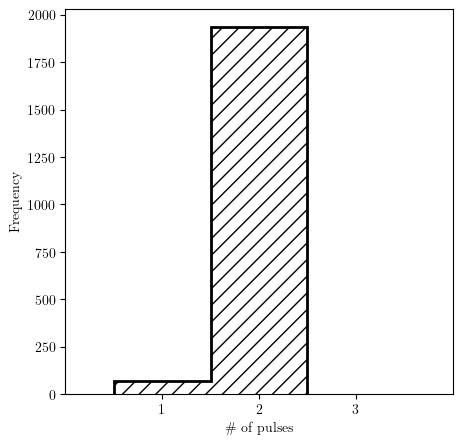

In [10]:
nan_free_columns = ~np.any(np.isnan(samples_uniform), axis=2)
count_per_row = np.count_nonzero(nan_free_columns, axis=1)
bins = np.arange(kbounds[0], kbounds[1]+1)

plt.figure(figsize=(5,5))
plt.hist(count_per_row, bins=bins, histtype="step", linewidth=2, facecolor="k", 
                        hatch="//", edgecolor="k",fill=False, align="left")
plt.xlim(0, kbounds[1]+1)
plt.xticks(bins)
plt.ylabel("Frequency")
plt.xlabel("\# of pulses")


We also run a normal reversible-jump MCMC using this proposal just to check the acceptance probability. I will use [Eryn](https://mikekatz04.github.io/Eryn/html/index.html) because it should be straightforwad to get it to work (the pulses example was borrowed from the Eryn tutorial).

In [11]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import uniform_dist
from eryn.moves import GaussianMove

Set up the priors

In [12]:
# describes priors for all leaves independently
priors = {
    "pulse": {
        0: uniform_dist(bounds[0][0], bounds[0][1]),          # amplitude
        1: uniform_dist(bounds[1][0], bounds[1][1]),  # mean
        2: uniform_dist(bounds[2][0], bounds[2][1]),        # sigma
    },
}

In [13]:
nwalkers = 20
ntemps = 5
ndims = {"pulse": int(dim)}
nleaves_max = {"pulse": int(kbounds[1])}
nleaves_min = {"pulse": int(kbounds[0])}
branch_names = ["pulse"]

# Initial coordinates
coords = {"pulse": np.zeros((ntemps, nwalkers, nleaves_max["pulse"], ndims["pulse"]))}

# this is the sigma for the multivariate Gaussian that sets starting points
# We need it to be very small to assume we are passed the search phase
# we will verify this is with likelihood calculations
sig1 = 0.001

# setup initial walkers to be the correct count (it will spread out)
for nn in range(nleaves_max["pulse"]):
    if nn >= len(p_inj):
        # not going to add parameters for these unused leaves
        continue
    # Draw from prior
    for pp in range(ndims["pulse"]):
        coords["pulse"][:, :, nn, pp] = priors["pulse"][pp].rvs(size=(ntemps, nwalkers))

# make sure to start near the proper setup
inds = {"pulse": np.zeros((ntemps, nwalkers, nleaves_max["pulse"]), dtype=bool)}

# turn False -> True for any binary in the sampler
inds["pulse"][:, :, :len(p_inj)] = True


Set up a Gaussian proposal for sampling

In [14]:
# for the Gaussian Move, will be explained later
factor = 0.001
cov = {"pulse": np.diag(np.ones(ndims["pulse"])) * factor}
moves = GaussianMove(cov)

Setup the sampler

In [15]:
ensemble = EnsembleSampler(
    nwalkers,
    ndims,
    mc.test_functions.multiple_pulses.llh_pulses_eryn,
    priors,
    args=[t, y, sigma],
    tempering_kwargs=dict(ntemps=ntemps),
    nbranches=len(branch_names),
    branch_names=branch_names,
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    moves=moves,
    rj_moves=True,  
)

Setup initial state

In [16]:
log_prior = ensemble.compute_log_prior(coords, inds=inds)
log_like = ensemble.compute_log_like(coords, inds=inds, logp=log_prior)[0]

# setup starting state
state = State(coords, log_like=log_like, log_prior=log_prior, inds=inds)

Sample!

In [17]:
nsteps = 5000
last_sample = ensemble.run_mcmc(state, nsteps, burn=1000, progress=True, thin_by=1)

100%|██████████| 5000/5000 [02:33<00:00, 32.54it/s]


Do corner plots and compare

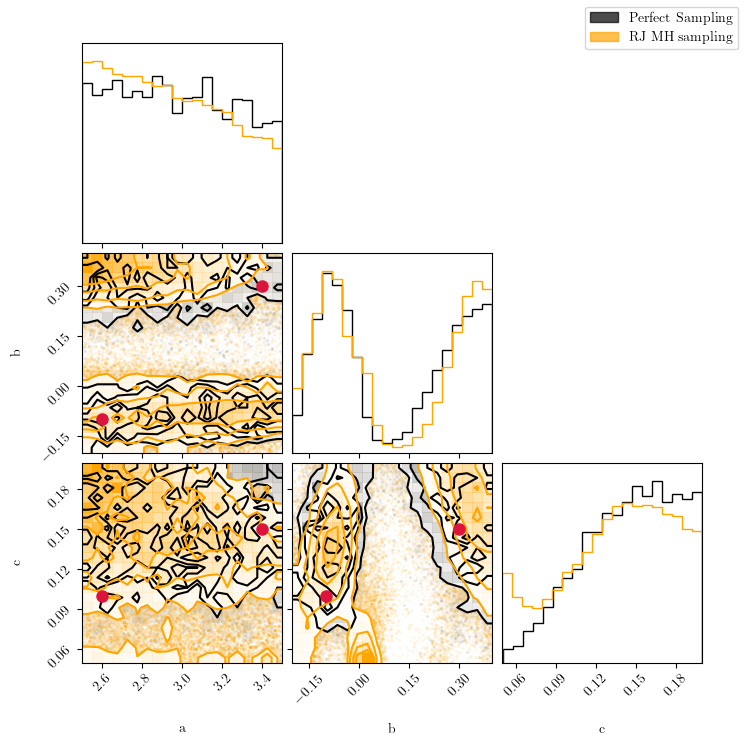

In [18]:
import matplotlib.patches as mpatches

figure = corner.corner(np.array(samples), labels=["a","b", "c"], plot_density=True, weights=np.ones(len(samples)) / len(samples))

samples_eryn = ensemble.get_chain(thin=3)["pulse"][:, 0].reshape(-1, ndims["pulse"])
samples_eryn = samples_eryn[~np.isnan(samples_eryn[:, 0])]

corner.corner(samples_eryn, fig=figure, color="orange", plot_density=True, weights=np.ones(len(samples_eryn)) / len(samples_eryn))

for pulse_params in np.array(p_inj):
    corner.overplot_points(figure, pulse_params[None], marker="o", color="crimson", markersize=8)


black_patch = mpatches.Patch(color='k', alpha=0.7, label='Perfect Sampling')
orange_patch = mpatches.Patch(color='orange', alpha=0.7, label='RJ MH sampling')
# Add legend to figure
figure.legend(handles=[black_patch, orange_patch], loc='upper right')

plt.show()

Make the histogram 

<>:11: SyntaxWarning: invalid escape sequence '\#'
<>:11: SyntaxWarning: invalid escape sequence '\#'
/var/folders/yz/xf637mpx56g2dvdv9d8v1fnm0000gn/T/ipykernel_82611/2732015332.py:11: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("\# of pulses")


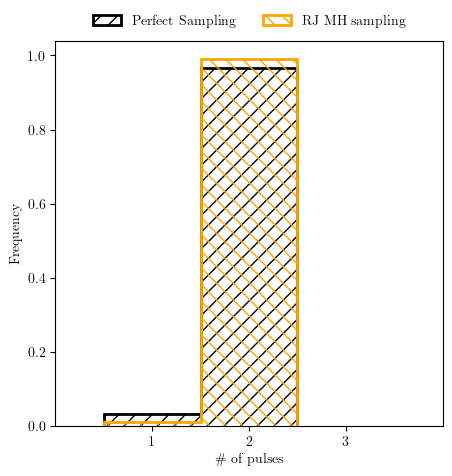

In [19]:
nleaves = ensemble.get_nleaves()["pulse"]

plt.figure(figsize=(5,5))
plt.hist(count_per_row, bins=bins, histtype="step", linewidth=2, facecolor="k", 
                        hatch="//", edgecolor="k",fill=False, align="left", density=True, label="Perfect Sampling")
plt.hist(nleaves[:,0].flatten(), bins=bins, histtype='step', linewidth=2, facecolor="orange", 
                        hatch=r"\\", edgecolor="orange",fill=False, align="left", density=True, label="RJ MH sampling")                       
plt.xlim(0, kbounds[1]+1)
plt.xticks(bins)
plt.ylabel("Frequency")
plt.xlabel("\# of pulses")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, frameon=False)

# $fin$